<a href="https://colab.research.google.com/github/Jorayala/AI_Master_UniAndes_2024/blob/main/Connect4_RL_MAIA_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Aprendizaje por Refuerzo Connect4 - Entrega final
### Presentado por:
- Jorge Ayala
- Monica Alvarez

Comenzamos importando las librerías necesarias para implementar el agente de aprendizaje por refuerzo que jugará al Conecta 4.
Estaslibrerías nos proporcionan herramientas para crear el entorno del juego, realizar cálculos numéricos, generar visualizaciones y manejar estructuras de datos.

- `gym`: Biblioteca que proporciona una interfaz estandarizada para crear entornos de aprendizaje por refuerzo.
- `os`: Proporciona funciones para interactuar con el sistema operativo.
- `numpy`: Biblioteca fundamental para computación numérica en Python, útil para manejar arreglos y realizar cálculos matemáticos.
- `matplotlib.pyplot`: Módulo para crear gráficos y visualizaciones de datos.
- `seaborn`: Biblioteca para visualización de datos basada en matplotlib, que ofrece una interfaz de alto nivel para crear gráficos estadísticos atractivos.
- `copy`: Proporciona funciones para copiar objetos en Python, tanto superficiales como profundas.
- `tensorflow`: Plataforma de código abierto para el aprendizaje automático, especialmente útil para construir y entrenar modelos de redes neuronales en aprendizaje profundo.


In [ ]:
# Importar librarias necesarias
import gym
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [ ]:
!pip install tensorflow
import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


La implementación de la clase `ConnectFourGym` define el entorno del juego Connect4 para el agente de aprendizaje por refuerzo. A continuación, se proporciona una breve explicación de cada función:

`__init__(self, agent2="random")`: Inicializa el entorno estableciendo las dimensiones del tablero, definiendo los espacios de acción y observación, inicializando la tabla Q y reiniciando el juego.

`reset(self)`: Reinicia el estado del juego creando un nuevo tablero vacío y estableciendo el jugador actual. Devuelve la observación inicial del entorno.

`_get_observation(self)`: Convierte el estado actual del tablero en una tupla de tuplas, lo que permite utilizarlo como clave en la tabla Q.

`change_reward(self, old_reward, done)`: Ajusta la recompensa basada en el resultado de la acción. Devuelve 1 si el agente gana, -1 si pierde, y una pequeña recompensa positiva por un movimiento válido.

`step(self, action)`: Ejecuta una acción en el entorno. Valida el movimiento, actualiza el tablero, verifica si el juego ha terminado, calcula la recompensa correspondiente y cambia el turno al siguiente jugador. También inicializa la entrada en la tabla Q para el nuevo estado si aún no existe.

`_check_done(self)`: Comprueba si el juego ha terminado debido a una victoria o a un empate (cuando el tablero está lleno).

`_check_winner(self)`: Verifica si el jugador actual ha ganado el juego comprobando todas las posibles combinaciones de cuatro fichas consecutivas en horizontal, vertical y diagonal.

`print_board(self)`: Imprime el estado actual del tablero en la consola para visualizar el progreso del juego.


In [ ]:
class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        self.rows = 6
        self.columns = 7
        self.action_space = gym.spaces.Discrete(self.columns)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.rows, self.columns), dtype=np.float64)
        self.q_table = {}  # Q-table en diccionario
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.columns), dtype=np.float64)
        self.current_player = 1
        return self._get_observation()

    def _get_observation(self):
        # Convertir el tablero a una tupla para usarla como clave en el diccionario
        return tuple(map(tuple, self.board))

    def change_reward(self, old_reward, done):
        if old_reward == 1:  # El agente ganó el juego
            return 1
        elif done:  # El oponente ganó el juego
            return -1
        else:  # Recompensa 1/42
            return 1 / (self.rows * self.columns)

    def step(self, action):
        if self.board[0, action] != 0:  # Invalid move
            reward, done = -10, True
        else:
            # Colocar la ficha en la fila más baja disponible
            for row in range(self.rows - 1, -1, -1):
                if self.board[row, action] == 0:
                    self.board[row, action] = self.current_player
                    break
            # Verificar victoria o empate
            done = self._check_done()
            reward = 1 if done and self._check_winner() else 0
            reward = self.change_reward(reward, done)
            self.current_player = 3 - self.current_player  # Cambiar de jugador

        # Visualizar el tablero solo si hay una victoria
            if done and reward == 1:
                self.print_board()


        # Obtener el estado actual como una tupla
        state = self._get_observation()

        # Verificar si el estado está en la tabla Q, si no, inicializarlo
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.columns)

        return self._get_observation(), reward, done, {}

    def _check_done(self):
        return np.all(self.board != 0) or self._check_winner()

    def _check_winner(self):
        # Verificar cuatro en línea (horizontal, vertical, diagonal)
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if self.board[row, col] == self.current_player == self.board[row, col + 1] == self.board[row, col + 2] == self.board[row, col + 3]:
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns):
                if self.board[row, col] == self.current_player == self.board[row + 1, col] == self.board[row + 2, col] == self.board[row + 3, col]:
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if self.board[row, col] == self.current_player == self.board[row + 1, col + 1] == self.board[row + 2, col + 2] == self.board[row + 3, col + 3]:
                    return True
        for row in range(3, self.rows):
            for col in range(self.columns - 3):
                if self.board[row, col] == self.current_player == self.board[row - 1, col + 1] == self.board[row - 2, col + 2] == self.board[row - 3, col + 3]:
                    return
    """
    def visualize_board(self):
        plt.imshow(self.board, cmap='cool', aspect='auto')
        plt.title(f'Current Player: {self.current_player}')
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.xticks(range(self.columns))
        plt.yticks(range(self.rows))
        plt.show() """
    def print_board(self):
        board_str = "\n".join([" ".join([str(int(cell)) for cell in row]) for row in self.board])
        print(f"Current Board:\n{board_str}\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Se crea el entorno del juego Connect4 y establecemos los parámetros clave para el algoritmo de Q-Learning: tasa de aprendizaje `alpha`, factor de descuento `gamma`, tasa de exploración inicial `epsilon`, su decaimiento `epsilon_decay`, la tasa mínima de exploración `epsilon_min` y el número de episodios `episodes`.

In [ ]:
# Crear el entorno de Connect4
env = ConnectFourGym()

# Parámetros de Q-Learning
alpha = 0.1  # Tasa de aprendizaje
gamma = 0.95  # Factor de descuento
epsilon = 1.0 # Tasa de exploración
epsilon_decay = 0.995 # Decaimiento de la tasa de exploración
epsilon_min = 0.01  # Tasa mínima de exploración
episodes = 1500  # Número de episodios



Se implementa el algoritmo de Q-Learning para entrenar al agente en el juego de Connect4. Creamos una lista rewards para almacenar las recompensas de cada episodio.
Entonces, en cada episodio:
- Reiniciamos el entorno y obtenemos el estado inicial.
- Utilizamos una estrategia epsilon-greedy para equilibrar exploración y explotación al seleccionar acciones.
- Ejecutamos la acción seleccionada en el entorno y obtenemos el nuevo estado, la recompensa y si el juego ha terminado.
- Convertimos los estados en índices únicos para utilizarlos en la Q-table.
- Actualizamos la Q-table utilizando la fórmula de actualización de Q-Learning
- Reducimos gradualmente el valor de epsilon para disminuir la exploración a medida que el agente aprende.
- Almacenamos la recompensa total obtenida en el episodio.

In [ ]:
# Lista para almacenar las recompensas de cada episodio
rewards = []
# Algoritmo de Q-Learning
for episode in range(episodes):
    state = env.reset()
    # Aplanar la tupla de estado y luego convertir a índice
    state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(state).flatten())]))
    done = False
    total_reward = 0
    while not done:
        # Equilibrio exploración-explotación
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explorar: seleccionar una acción al azar
        else:
            #Si state_index no está en la q_table, inicializarlo
            if state_index not in env.q_table:
                env.q_table[state_index] = np.zeros(env.columns)
            action = np.argmax(env.q_table[state_index])  # Exploit: select the action with max value (greedy)

        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        # Aplanar la tupla de next_state y luego convertir a índice
        next_state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(next_state).flatten())]))

        # Actualización de Q-learning
        # Si next_state_index no está en la q_table, inicializarlo
        if next_state_index not in env.q_table:
            env.q_table[next_state_index] = np.zeros(env.columns)

        best_next_action = np.argmax(env.q_table[next_state_index])
        # Acceder al valor Q usando next_state_index y best_next_action como índices
        td_target = reward + gamma * env.q_table[next_state_index][best_next_action] * (not done)
        # Asegurarse de que state_index está en la q_table antes de acceder a él
        if state_index not in env.q_table:
            env.q_table[state_index] = np.zeros(env.columns)

        td_error = td_target - env.q_table[state_index][action] # Acceder al valor Q usando state_index y action como índices
        env.q_table[state_index][action] += alpha * td_error # Actualizar el valor Q

        state_index = next_state_index

    ## Almacenar la recompensa total del episodio
    rewards.append(total_reward)

    # Disminuir epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Visualizar el tablero cada 1000 episodios
    if episode % 1000 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")
        env.print_board()

# Guardar la Q-table
np.save("connect4_q_table.npy", env.q_table)

Streaming output truncated to the last 5000 lines.
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0

A continuación, se define la función `moving_average`, que calcula el promedio móvil de una serie de datos utilizando una ventana deslizante.
Se utiliza una función de promedio móvil para suavizar las recompensas por episodio, reduciendo el ruido y la variabilidad de los datos originales. Esto permite identificar patrones y tendencias generales en el desempeño del modelo. Además, se grafican tanto las recompensas originales como las suavizadas para facilitar la comparación visual y el análisis del progreso.

  - La recompensa original por episodio (en color azul claro).
  - La recompensa suavizada con promedio móvil (en azul oscuro).


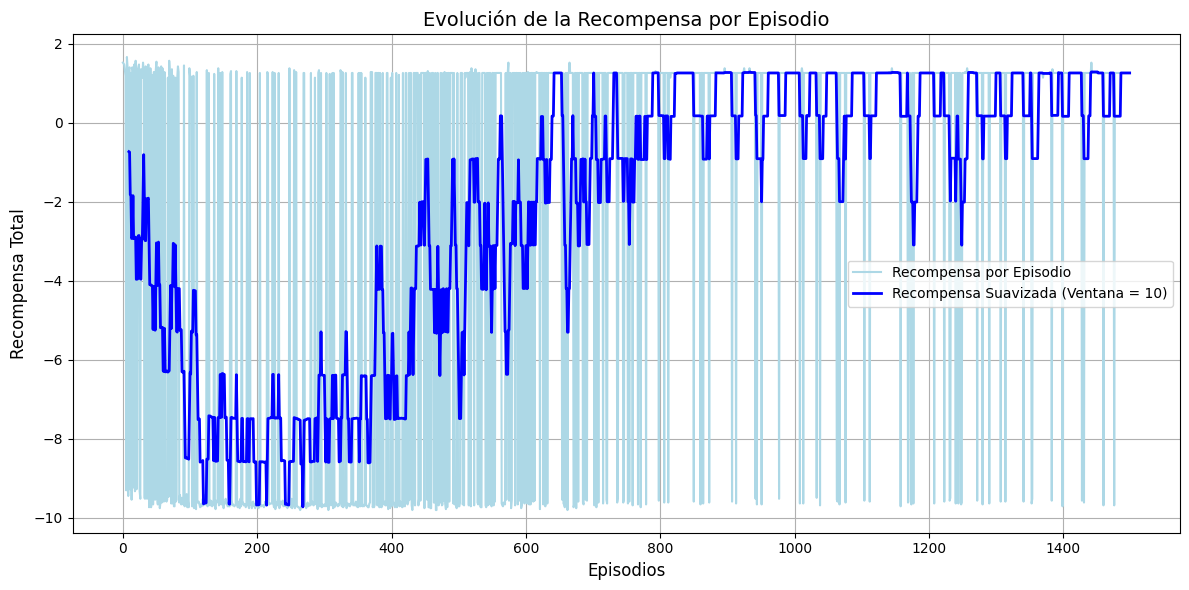

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 10
smoothed_rewards = moving_average(rewards, window_size)
episodes_smoothed = np.arange(window_size - 1, len(rewards))

plt.figure(figsize=(12, 6))
plt.plot(rewards, color='lightblue', label='Recompensa por Episodio')
plt.plot(episodes_smoothed, smoothed_rewards, color='blue', linewidth=2, label=f'Recompensa Suavizada (Ventana = {window_size})')
plt.xlabel('Episodios', fontsize=12)
plt.ylabel('Recompensa Total', fontsize=12)
plt.title('Evolución de la Recompensa por Episodio', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Las líneas en azul claro representan las recompensas originales, que son altamente variables y presentan fluctuaciones significativas. Por otro lado, la línea azul oscuro, que corresponde a las recompensas suavizadas mediante un promedio móvil de ventana 10, permite identificar una tendencia general de mejora en el desempeño a medida que avanza el entrenamiento. Esto sugiere que el modelo está aprendiendo gradualmente, aunque aún persisten episodios con valores bajos, lo que podría indicar áreas de mejora en la estabilidad del aprendizaje.

Se grafica la disminución de epsilon a lo largo de los episodios para visualizar cómo el agente reduce la exploración y aumenta la explotación. Utilizamos matplotlib para trazar los valores de epsilon en función de los episodios.

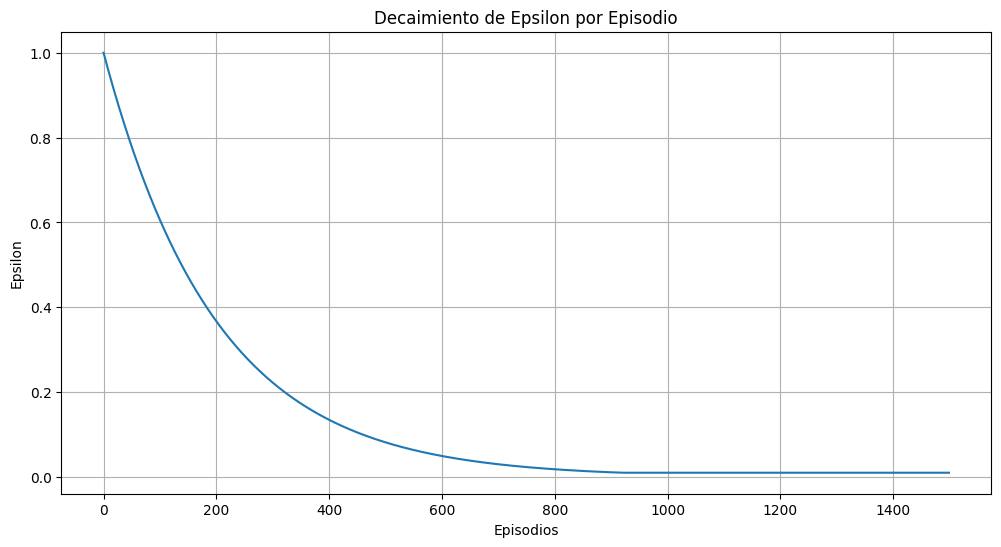

In [ ]:
epsilons = [max(epsilon_min, epsilon_decay**i) for i in range(episodes)]
plt.figure(figsize=(12, 6))
plt.plot(range(episodes), epsilons)
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decaimiento de Epsilon por Episodio')
plt.grid(True)
plt.show()


La gráfica representa el decaimiento exponencial del parámetro ϵ. Al inicio, ϵ tiene un valor alto, lo que permite al agente explorar ampliamente el espacio de estados y acciones. A medida que avanza el entrenamiento, ϵ disminuye gradualmente, favoreciendo la explotación de las políticas aprendidas. Se puede observar que ϵ se estabiliza aproximadamente después de 900 episodios, alcanzando un valor mínimo cercano a cero y permaneciendo casi constante en los episodios finales.

Se define la función `test_agent` para evaluar el rendimiento del agente entrenado durante varios episodios. En cada episodio, el agente selecciona acciones basadas en la Q-table y juega hasta que el juego termina, permitiendo observar su comportamiento y efectividad.


In [ ]:
# Test the trained agent
def test_agent(env, q_table, episodes=10):
    for episode in range(episodes):
        state = env.reset()
        # Flatten the state tuple and then convert to index
        state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(state).flatten())]))
        done = False
        while not done:
            # Accessing q_table with the integer index directly
            # If state_index is not in q_table, default to zeros
            action = np.argmax(q_table.get(state_index, np.zeros(env.columns)) if isinstance(q_table, dict) else \
                                (q_table[state_index] if state_index in q_table else np.zeros(env.columns)))
            state, reward, done, _ = env.step(action)
            # Flatten the state tuple and then convert to index
            state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(state).flatten())]))

Se carga la Q-table previamente entrenada, evaluamos el rendimiento del agente en varios episodios y visualizamos los valores Q promedio para cada acción (columna) utilizando matplotlib.

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1

Current Board:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
2 0 0 0 0 0 0
2 1 0 0 0 0 0
2 2 1 0 1 0 0
2 1 1 0 2 0 1



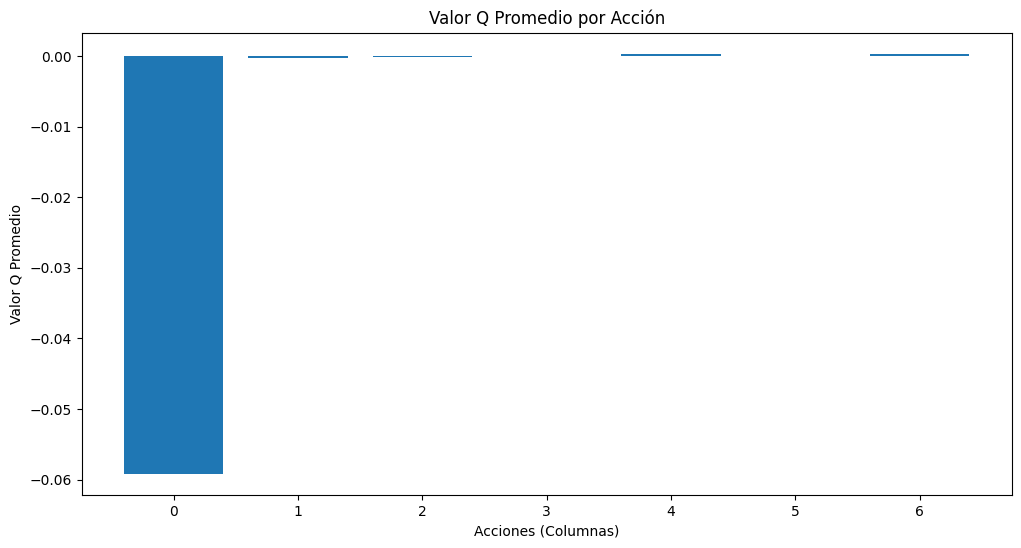

In [ ]:
# Load and test the trained Q-table
q_table = np.load("connect4_q_table.npy", allow_pickle=True).item() # Load as dictionary using .item()
test_agent(env, q_table, episodes=5)

# Visualize the Q-table using matplotlib
def visualize_q_table(q_table, columns=7):
    # Check if the Q-table is a dictionary and convert it to a numpy array if needed
    if isinstance(q_table, dict):
        q_table_array = np.array(list(q_table.values()))
    else:
        q_table_array = q_table

    # If q_table_array is not empty, calculate the average Q-values
    if q_table_array.size > 0:
        avg_q_values = np.mean(q_table_array, axis=0)
        plt.figure(figsize=(12, 6))
        plt.bar(range(columns), avg_q_values)
        plt.xlabel('Acciones (Columnas)')
        plt.ylabel('Valor Q Promedio')
        plt.title('Valor Q Promedio por Acción')
        plt.show()
    else:
        print("Q-table está vacía.")

# Call the visualization function
visualize_q_table(q_table, env.columns)  # Pass env.columns for flexibility

Finalmente, visualizamos la distribución de los valores Q para cada acción (columna) utilizando un diagrama de cajas (boxplot) con seaborn. Esto nos permite analizar la variabilidad y el rango de los valores Q aprendidos por el agente para cada acción.

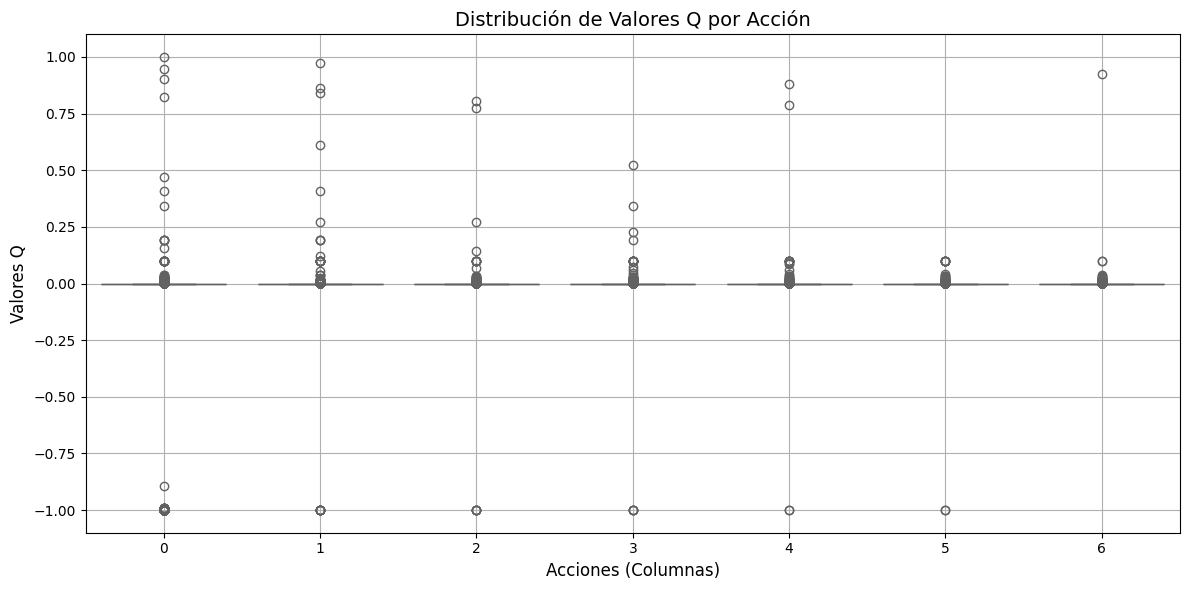

In [ ]:
def visualize_q_table_distribution(q_table, columns=7):
    if isinstance(q_table, dict):
        q_values = np.array(list(q_table.values()))
    else:
        q_values = q_table

    if q_values.size > 0:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=q_values, palette="Set3")
        plt.xlabel('Acciones (Columnas)', fontsize=12)
        plt.ylabel('Valores Q', fontsize=12)
        plt.title('Distribución de Valores Q por Acción', fontsize=14)
        plt.xticks(range(columns), range(columns))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("La Q-table está vacía. No se puede visualizar.")

# Llamar a la función de visualización
visualize_q_table_distribution(q_table, env.columns)


 En la grafica anterios, se observa que la mayoría de los valores Q están concentrados cerca de cero, lo que podría indicar incertidumbre o falta de aprendizaje significativo para algunas acciones. Sin embargo, también hay valores extremos positivos y negativos, lo que refleja que ciertas acciones son evaluadas como claramente mejores o peores en contextos específicos, esto sugiere que el modelo está comenzando a distinguir entre las diferentes acciones.